# mT5

In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration

import re, glob, random
from collections import defaultdict
from itertools import groupby
import pandas as pd
import matplotlib.pyplot as plt

from data_utils.utils import *

/home/vietnq/.miniconda3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH = 1024
model_id = 'google/mt5-base'

In [3]:
# Setup tokenizer
tokenizer = MT5TokenizerFast.from_pretrained(model_id)

print('BOS:', tokenizer.bos_token)
print('SEP:', tokenizer.sep_token)
print('PAD:', tokenizer.pad_token)
print('EOS:', tokenizer.eos_token)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/vietnq/.miniconda3/envs/thesis/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


BOS: None
SEP: None
PAD: <pad>
EOS: </s>


### 1. Dataset `Universal-NER/Pile-NER-type`

#### Load dataset

In [43]:
# output repo in huggingface
output_repo = 'en-mT5-ner-open_domain'
eval_repo = 'eval-en-mT5-ner-open_domain'

In [44]:
en_open_ner = load_dataset('Universal-NER/Pile-NER-type', split='train')
en_open_ner

Dataset({
    features: ['id', 'conversations'],
    num_rows: 45889
})

In [45]:
en_open_ner[232]

{'id': 'ner_232',
 'conversations': [{'from': 'human',
   'value': 'Text: N-(X-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide (with X = 2 and 4). The structures of N-(2-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide and N-(4-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide, both C16H13ClN2O4S, are stabilized by extensive intramolecular hydrogen bonds. The 4-chloro derivative forms dimeric pairs of molecules lying about inversion centres as a result of intermolecular N-H...O hydrogen bonds, forming 14-membered rings representing an R2(2)(14) motif; the 2-chloro derivative is devoid of any such intermolecular hydrogen bonds. The heterocyclic thiazine rings in both structures adopt half-chair conformations.'},
  {'from': 'gpt', 'value': "I've read this text."},
  {'from': 'human', 'value': 'What describes Relationship in the text?'},
  {'from': 'gpt', 'value': '[]'},
  {'from': 'human', 'value

#### Make instruction dataset and clean it

In [46]:
# Make instruction data
def make_instruction_data(samples):
    ids, texts, labels, entity_types, input_paras = [], [], [], [], []

    for sample_id, sample_conv in zip(samples['id'], samples['conversations']):
        cur_input_para = sample_conv[0]['value'].strip()
        for i in range(2, len(sample_conv), 2):
            cur_id = str(sample_id) + '_' + str(i//2)

            user_question = sample_conv[i]['value'].strip()
            cur_entity_type = re.search(r'(?<=describes\s)(.*?)(?=\sin)', user_question).group(0).strip()
            cur_instruction = user_question.replace(cur_entity_type, cur_entity_type.lower())
            cur_text = prompt_input({
                'instruction': cur_instruction,
                'input': cur_input_para,
            })

            cur_label = sample_conv[i+1]['value'].strip()

            ids.append(cur_id)
            texts.append(cur_text)
            labels.append(cur_label)
            entity_types.append(cur_entity_type)
            input_paras.append(cur_input_para)
    return {
        'id': ids,
        'text': texts,
        'label': labels,
        'entity_type': entity_types,
        'input_para': input_paras,
    }

print("> Making instruction dataset...")
en_open_ner_instruct = en_open_ner.map(
    make_instruction_data, batched=True, remove_columns=en_open_ner.column_names
)
print("labelled ds:", en_open_ner_instruct)

> Making instruction dataset...


Map: 100%|██████████| 45889/45889 [00:09<00:00, 4604.17 examples/s]

labelled ds: Dataset({
    features: ['id', 'text', 'label', 'entity_type', 'input_para'],
    num_rows: 358181
})


In [47]:
df_raw = pd.DataFrame(en_open_ner_instruct)
df_raw

,id,text,label,entity_type,input_para
0,ner_0_1,"Below is an instruction that describes a task,...","[""function""]",programming concept,Text: Q:\n\nPosition character based on enemy ...
1,ner_0_2,"Below is an instruction that describes a task,...","[""lua""]",programming language,Text: Q:\n\nPosition character based on enemy ...
2,ner_0_3,"Below is an instruction that describes a task,...",[],database,Text: Q:\n\nPosition character based on enemy ...
3,ner_0_4,"Below is an instruction that describes a task,...","[""myPosition"", ""enemyPosition"", ""xValue"", ""yVa...",variable,Text: Q:\n\nPosition character based on enemy ...
4,ner_0_5,"Below is an instruction that describes a task,...",[],Date,Text: Q:\n\nPosition character based on enemy ...
...,...,...,...,...,...
358176,ner_45888_10,"Below is an instruction that describes a task,...","[""factorial analyses of variance""]",method,Text: Automatic and Controlled Emotion Regulat...
358177,ner_45888_11,"Below is an instruction that describes a task,...",[],Person,Text: Automatic and Controlled Emotion Regulat...
358178,ner_45888_12,"Below is an instruction that describes a task,...","[""young adults"", ""older adults""]",group,Text: Automatic and Controlled Emotion Regulat...
358179,ner_45888_13,"Below is an instruction that describes a task,...",[],email,Text: Automatic and Controlled Emotion Regulat...


In [48]:
type(df_raw['label'][0])

str

In [49]:
df = df_raw.copy()
df['entity_type_lower'] = df['entity_type'].str.lower()

In [50]:
counts = df['entity_type'].value_counts(sort=True)
counts.size, counts[:20]

(15461,
 entity_type
 person          13706
 Person          11857
 organization    11831
 Organization    11157
 location        10196
 Location         9479
 concept          7523
 Date             6304
 product          6262
 date             5071
 event            3773
 group            3701
 technology       3463
 Event            3032
 object           3015
 software         2892
 Product          2821
 measurement      2624
 Nationality      2571
 variable         2522
 Name: count, dtype: int64)

In [51]:
counts = df['entity_type_lower'].value_counts(sort=True)
counts.size, counts[:20]

(12870,
 entity_type_lower
 person               25929
 organization         23231
 location             19888
 date                 11742
 concept               9908
 product               9178
 event                 6887
 technology            4866
 group                 4530
 medical condition     3853
 nationality           3610
 object                3602
 software              3502
 disease               3212
 measurement           3131
 time                  2954
 title                 2851
 country               2757
 variable              2670
 process               2561
 Name: count, dtype: int64)

In [52]:
# No negative examples vs total
df[df['label'] == '[]'].shape[0], df.shape[0]

(119862, 358181)

In [53]:
cleaned_df = df.drop_duplicates(subset=['input_para', 'entity_type_lower', 'label'])
df.shape, cleaned_df.shape

((358181, 6), (354402, 6))

In [54]:
en_open_ner_cleaned = Dataset.from_pandas(cleaned_df[['id', 'text', 'label']], preserve_index=False)
en_open_ner_cleaned

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 354402
})

#### Convey the lengths of samples in dataset

Map:   0%|          | 0/354402 [00:00<?, ? examples/s]

Map: 100%|██████████| 354402/354402 [05:14<00:00, 1127.39 examples/s]


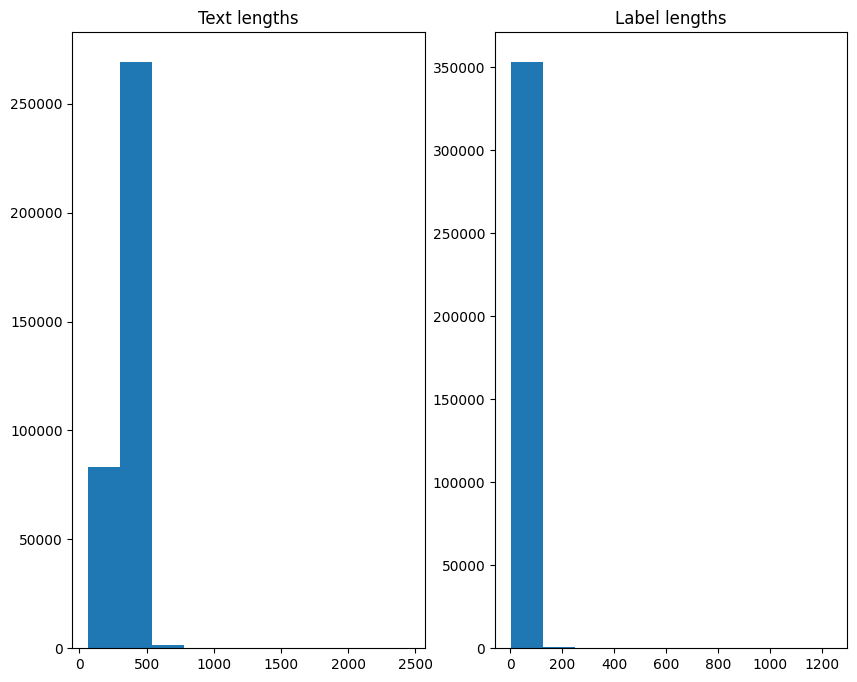

Max text length: 2449
Max label length: 1237
Current limit: MAX_LENGTH = 1024


In [55]:
en_open_ner_cleaned_with_length = en_open_ner_cleaned.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(en_open_ner_cleaned_with_length['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(en_open_ner_cleaned_with_length['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(en_open_ner_cleaned_with_length['len_text']))
print('Max label length:', max(en_open_ner_cleaned_with_length['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

Drop those samples that having lengths exceed the pre-defined MAX LENGTH

In [56]:
en_open_ner_cleaned_dropped = en_open_ner_cleaned_with_length.filter(
    lambda example: (example['len_text'] <= MAX_LENGTH) and (example['len_label'] <= MAX_LENGTH)
)

Filter: 100%|██████████| 354402/354402 [00:06<00:00, 57695.01 examples/s]


Map:   0%|          | 0/354261 [00:00<?, ? examples/s]

Map: 100%|██████████| 354261/354261 [05:00<00:00, 1177.94 examples/s]


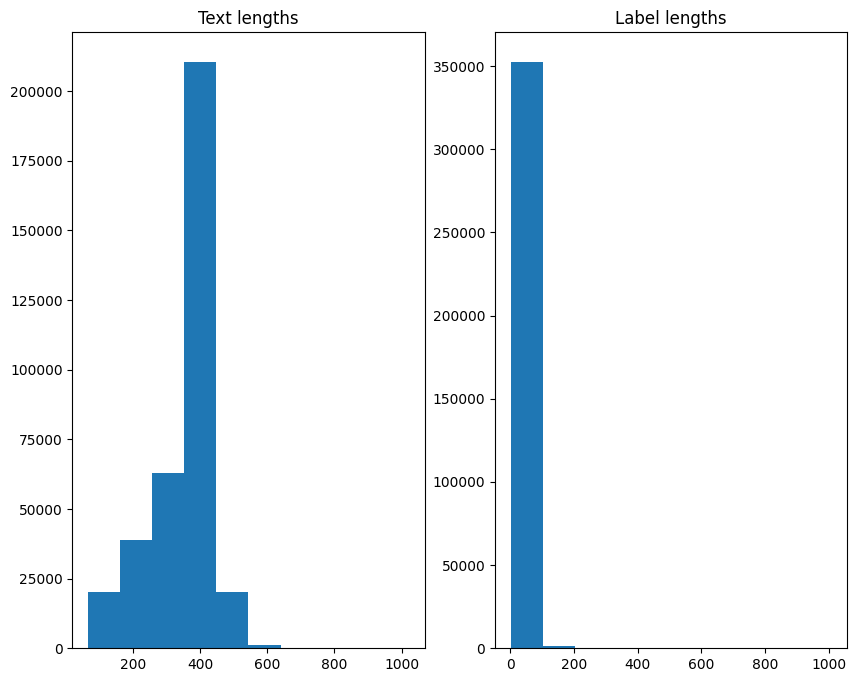

Max text length: 1021
Max label length: 1008
Current limit: MAX_LENGTH = 1024


In [57]:
token_lengths = en_open_ner_cleaned_dropped.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(token_lengths['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(token_lengths['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(token_lengths['len_text']))
print('Max label length:', max(token_lengths['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [21]:
en_open_ner_cleaned_dropped

Dataset({
    features: ['id', 'text', 'label', 'len_text', 'len_label'],
    num_rows: 354261
})

#### Create tokenized dataset

In [22]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
en_open_ner_tokenized = en_open_ner_cleaned_dropped.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=["text", "label", "len_text", "len_label"],
)

print(">> Dataset is ready:")
print(en_open_ner_tokenized)

> Tokenizing dataset...


Map: 100%|██████████| 354261/354261 [01:11<00:00, 4925.24 examples/s]

>> Dataset is ready:
Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 354261
})


In [23]:
tokenizer.decode(en_open_ner_tokenized[19]['input_ids'])

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes norp in the text? ### Input: Text: Gino Mäder Gino Mäder (born 4 January 1997) is a Swiss road and track cyclist, who currently rides for UCI WorldTeam. He competed at the 2016 UEC European Track Championships in the team pursuit event. Major results 2014 4th Road race, European Junior Road Championships 9th Overall Grand Prix Rüebliland 9th Overall Tour du Pays de Vaud 2015 1st Time trial, National Junior Road Championships 2nd Overall Tour du Pays de Vaud 1st Prologue & Stage 1 2nd Overall Grand Prix Rüebliland 5th Time trial, UCI Junior Road World Championships 2017 3rd Piccolo Giro di Lombardia 6th Rund um den Finanzplatz Eschborn-Frankfurt U23 2018 Tour Alsace 1st Points classification 1st Stage 4 1st Stage 4 Ronde de l'Isard 2nd Time trial, National Under–23 Road Championships 2nd Overall Tou

In [24]:
tokenizer.decode(en_open_ner_tokenized[19]['labels'])

'[]</s>'

In [26]:
print(f"> Pushing to hub: {output_repo}")
en_open_ner_tokenized.push_to_hub(output_repo)

> Pushing to hub: en-mT5-ner-open_domain


Uploading the dataset shards: 100%|██████████| 2/2 [00:23<00:00, 11.53s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/en-mT5-ner-open_domain/commit/00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', commit_message='Upload dataset', commit_description='', oid='00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', pr_url=None, pr_revision=None, pr_num=None)

### 2. Dataset VLSP 2021 - *GOLD* data

In [23]:
# output repo in huggingface
output_repo = 'vi-mT5-ner-vlsp-GOLD'
eval_repo = 'eval-vi-ner-vlsp-GOLD'

In [24]:
data_dirs = [
    'datasets/NER_VLSP_2021/NER-Data-Muc',
    'datasets/NER_VLSP_2021/Data-Muc-Addition'
]
data_paths = [path for data_dir in data_dirs for path in glob.glob(data_dir+'/*')]
len(data_paths)

1500

In [25]:
# dev paths are path that start with "0_dev"
# test paths are path that start with "1_test"
# train paths are the rest
dev_paths = [path for path in data_paths if path.split('/')[-1].startswith('0_dev')]
test_paths = [path for path in data_paths if path.split('/')[-1].startswith('1_test')]
train_paths = [path for path in data_paths if (path not in dev_paths) and (path not in test_paths)]

len(train_paths), len(dev_paths), len(test_paths)

(1050, 210, 240)

In [26]:
vi_vlsp_ner = DatasetDict({
    'train': Dataset.from_dict({'file_path': train_paths, 'split': ['train']*len(train_paths)}),
    'dev': Dataset.from_dict({'file_path': dev_paths, 'split': ['dev']*len(dev_paths)}),
    'test': Dataset.from_dict({'file_path': test_paths, 'split': ['test']*len(test_paths)}),
})
vi_vlsp_ner

DatasetDict({
    train: Dataset({
        features: ['file_path', 'split'],
        num_rows: 1050
    })
    dev: Dataset({
        features: ['file_path', 'split'],
        num_rows: 210
    })
    test: Dataset({
        features: ['file_path', 'split'],
        num_rows: 240
    })
})

In [27]:
def parse_muc_data(text):
    # parse each sample NER data text into a dictionary:
    # key "text": The text after remove all labels
    # key "entities": a list of tuples, each tuple contains the entity type and the entity text
    samples = defaultdict(list)
    
    for line in text.split('\n'):
        if not line:
            continue        
        
        # extract entities
        entities = re.findall(r'<ENAMEX TYPE="([^"]*)">([^<]*)</ENAMEX>', line)
        # remove all labels to get the text
        line = re.sub(r'<ENAMEX[^>]*>', '', line)
        line = re.sub(r'</ENAMEX>', '', line)

        entity_dict = defaultdict(list)
        for entity_type, entity_text in set(entities):
            entity_dict[entity_type].append(entity_text)

        for entity_type, entity_texts in entity_dict.items():
            samples['input_para'].append(line)
            samples['entity_type'].append(entity_type)
            samples['label'].append(entity_texts)

    return samples

def read_muc_files(file_paths, splits):
    # read all MUC files and parse them
    samples = defaultdict(list)
    for file_path, split in zip(file_paths, splits):
        with open(file_path, 'r') as f:
            text = f.read()
            samples_in_text = parse_muc_data(text)
            samples['input_para'].extend(samples_in_text['input_para'])
            samples['entity_type'].extend(samples_in_text['entity_type'])
            samples['label'].extend(samples_in_text['label'])
            samples['split'].extend([split]*len(samples_in_text['input_para']))
            
    return samples

vi_vlsp_ner_parsed = vi_vlsp_ner.map(
    lambda x: read_muc_files(x['file_path'], x['split']),
    batched=True,
    remove_columns=['file_path']
)
vi_vlsp_ner_parsed

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map: 100%|██████████| 240/240 [00:00<00:00, 3502.88 examples/s]


DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 25970
    })
    dev: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 4373
    })
    test: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 8619
    })
})

In [28]:
# ref: https://learn.microsoft.com/en-in/azure/ai-services/language-service/named-entity-recognition/concepts/named-entity-categories?tabs=ga-api#category-location

# entity_types_to_drop = ['*', 'MISCELLANEOUS']
entity_type_map = {
    'ADDRESS': ['address'],
    'DATETIME': ['datetime'],
    'DATETIME-DATE': ['date', 'calendar date', 'datetime-date'],
    'DATETIME-DATERANGE': ['date range', 'datetime-daterange'],
    'DATETIME-DURATION': ['duration', 'datetime-duration'],
    'DATETIME-SET': ['set', 'repeated time', 'datetime-set'],
    'DATETIME-TIME': ['time', 'time of day', 'datetime-time'],
    'DATETIME-TIMERANGE': ['time range', 'datetime-timerange'],
    'EMAIL': ['email'],
    'EVENT': ['event'],
    'EVENT-CUL': ['cultural event', 'holiday', 'event-cul'],
    'EVENT-GAMESHOW': ['game show', 'event-gameshow'],
    'EVENT-NATURAL': ['natural event', 'event-natural'],
    'EVENT-SPORT': ['sport event', 'event-sport'],
    'IP': ['ip'],
    'LOCATION': ['location'],
    'LOCATION-GEO': ['geographical location', 'location-geo'],
    'LOCATION-GPE': ['geopolitical entity', 'location-gpe'],
    'LOCATION-STRUC': ['manmade structure', 'location-struc'],
    'ORGANIZATION': ['organization'],
    'ORGANIZATION-MED': ['medical organization', 'organization-med'],
    'ORGANIZATION-SPORTS': ['sport-related organization', 'organization-sports'],
    'ORGANIZATION-STOCK': ['stock organization', 'organization-stock'],
    'PERSON': ['person'],
    'PERSONTYPE': ['person role', 'persontype'],
    'PHONENUMBER': ['phone number', 'phonenumber'],
    'PRODUCT': ['product'],
    'PRODUCT-AWARD': ['award', 'product-award'],
    'PRODUCT-COM': ['product-com'],
    'PRODUCT-LEGAL': ['legal', 'product-legal'],
    'QUANTITY': ['quantity'],
    'QUANTITY-AGE': ['age', 'quantity-age'],
    'QUANTITY-CUR': ['currency', 'quantity-cur'],
    'QUANTITY-DIM': ['dimension', 'measurements', 'quantity-dim'],
    'QUANTITY-NUM': ['number', 'quantity-num'],
    'QUANTITY-ORD': ['ordinal number', 'quantity-ord'],
    'QUANTITY-PER': ['percentage', 'quantity-per'],
    'QUANTITY-TEM': ['temperature', 'quantity-tem'],
    'SKILL': ['skill'],
    'URL': ['url'],
}

def update_entity_type(samples):
    new_samples = defaultdict(list)
    for input_para, label, entity_type, split in zip(samples['input_para'], samples['label'], samples['entity_type'], samples['split']):
        if entity_type in entity_type_map:
            new_samples['input_para'].append(input_para)
            new_samples['label'].append(label)
            new_samples['entity_type'].append(
                random.choice(entity_type_map[entity_type])
            )
            new_samples['split'].append(split)

    return new_samples

vi_vlsp_ner_renamed = vi_vlsp_ner_parsed.map(
    lambda x: update_entity_type(x),
    batched=True

)
vi_vlsp_ner_renamed

Map:   0%|          | 0/25970 [00:00<?, ? examples/s]

Map: 100%|██████████| 8619/8619 [00:00<00:00, 78337.64 examples/s]


DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 25587
    })
    dev: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 4304
    })
    test: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 8543
    })
})

In [29]:
# turn into dataframe
df = pd.concat([
        vi_vlsp_ner_renamed['train'].to_pandas(), 
        vi_vlsp_ner_renamed['dev'].to_pandas(), 
        vi_vlsp_ner_renamed['test'].to_pandas()
    ], 
    ignore_index=True)
df

,split,input_para,entity_type,label
0,train,Tổng LĐLĐVN : Sẽ tuyên dương 100 Chủ tịch Công...,organization,[Tổng LĐLĐVN]
1,train,100 Chủ tịch Công đoàn cơ sở ( CĐCS ) trong cá...,location,[Hà Nội]
2,train,100 Chủ tịch Công đoàn cơ sở ( CĐCS ) trong cá...,organization,[Tổng LĐLĐVN]
3,train,Đoàn Chủ tịch Liên đoàn vừa ban hành Kế hoạch ...,organization,[Tổng LĐLĐVN]
4,train,"Theo Phó Chủ tịch Tổng LĐLĐVN Mai Đức Chính , ...",person role,[Phó Chủ tịch]
...,...,...,...,...
38429,test,- Rồi xôn xao chuyện lương cô giáo mầm non với...,quantity-cur,"[1,3 triệu đồng]"
38430,test,- Chưa hết. Trong khi đội ngũ tiến sĩ của nền ...,quantity,[9000 tiến sĩ]
38431,test,- Chưa hết. Trong khi đội ngũ tiến sĩ của nền ...,currency,[12.000 tỷ]
38432,test,"- Có lẽ chỉ chấm phá như thế cũng đủ để thấy, ...",datetime,[năm 2017]


In [30]:
print(type(df.loc[0, 'label']))
df['label'] = df['label'].map(lambda x: x.tolist())
print(type(df.loc[0, 'label']))

<class 'numpy.ndarray'>
<class 'list'>


In [31]:
# create instruction prompt
df['prompt'] = df.apply(
    lambda x: prompt_input({
        'instruction': ner_instruction(x['entity_type']),
        'input': x['input_para'],
    }),
    axis=1
)
df

,split,input_para,entity_type,label,prompt
0,train,Tổng LĐLĐVN : Sẽ tuyên dương 100 Chủ tịch Công...,organization,[Tổng LĐLĐVN],"Below is an instruction that describes a task,..."
1,train,100 Chủ tịch Công đoàn cơ sở ( CĐCS ) trong cá...,location,[Hà Nội],"Below is an instruction that describes a task,..."
2,train,100 Chủ tịch Công đoàn cơ sở ( CĐCS ) trong cá...,organization,[Tổng LĐLĐVN],"Below is an instruction that describes a task,..."
3,train,Đoàn Chủ tịch Liên đoàn vừa ban hành Kế hoạch ...,organization,[Tổng LĐLĐVN],"Below is an instruction that describes a task,..."
4,train,"Theo Phó Chủ tịch Tổng LĐLĐVN Mai Đức Chính , ...",person role,[Phó Chủ tịch],"Below is an instruction that describes a task,..."
...,...,...,...,...,...
38429,test,- Rồi xôn xao chuyện lương cô giáo mầm non với...,quantity-cur,"[1,3 triệu đồng]","Below is an instruction that describes a task,..."
38430,test,- Chưa hết. Trong khi đội ngũ tiến sĩ của nền ...,quantity,[9000 tiến sĩ],"Below is an instruction that describes a task,..."
38431,test,- Chưa hết. Trong khi đội ngũ tiến sĩ của nền ...,currency,[12.000 tỷ],"Below is an instruction that describes a task,..."
38432,test,"- Có lẽ chỉ chấm phá như thế cũng đủ để thấy, ...",datetime,[năm 2017],"Below is an instruction that describes a task,..."


In [32]:
df.iloc[0]['prompt']

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: What describes organization in the text?\n\n### Input: Tổng LĐLĐVN : Sẽ tuyên dương 100 Chủ tịch Công đoàn cơ sở tiêu biểu\n\n### Response:\n'

In [33]:
df.iloc[0]['label']

['Tổng LĐLĐVN']

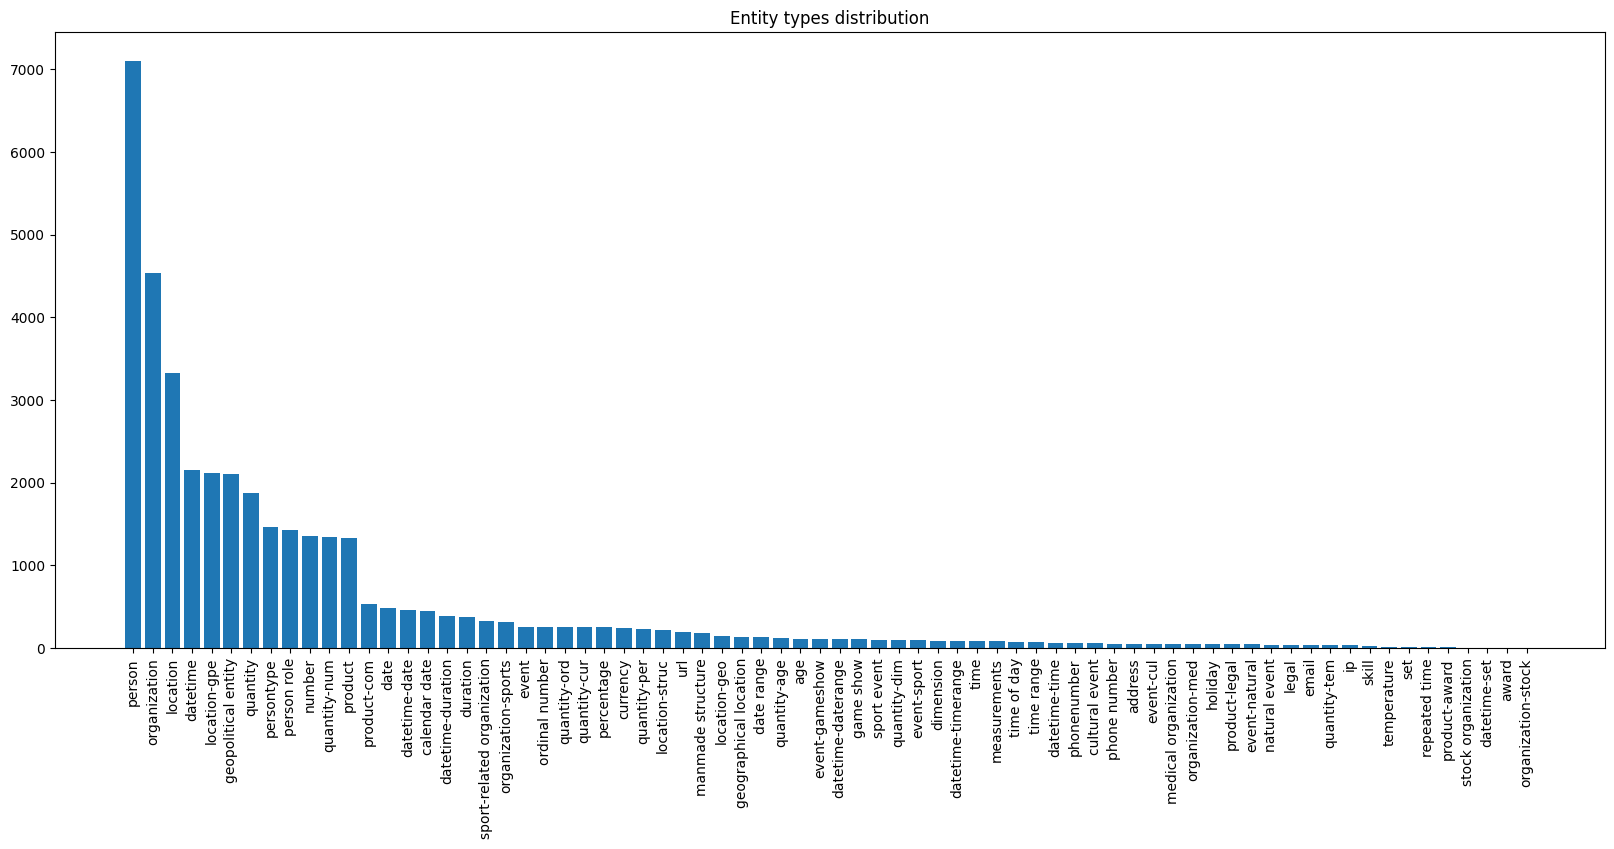

In [34]:
entity_types_count = df['entity_type'].value_counts()

# plot bar chart
plt.figure(figsize=(20, 8))
plt.bar(entity_types_count.index, entity_types_count.values)
plt.xticks(rotation=90)
plt.title('Entity types distribution')
plt.show()


In [35]:
df['len_text'] = df['input_para'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['len_label'] = df['label'].apply(lambda x: len(tokenizer(str(x))['input_ids']))
df['len_prompt'] = df['prompt'].apply(lambda x: len(tokenizer(x)['input_ids']))
df.describe()

,len_text,len_label,len_prompt
count,38434.000000,38434.000000,38434.000000
mean,129.044180,11.768148,192.047068
std,93.469521,10.771210,93.486774
min,2.000000,4.000000,64.000000
25%,73.000000,6.000000,137.000000
50%,115.000000,8.000000,178.000000
75%,163.000000,14.000000,226.000000
max,1799.000000,519.000000,1864.000000


In [36]:
# Only take samples with text length < 512
df = df[df['len_text'] < 512]
df.describe()

,len_text,len_label,len_prompt
count,38250.000000,38250.000000,38250.000000
mean,125.899608,11.672732,188.902693
std,78.020236,9.523953,78.044156
min,2.000000,4.000000,64.000000
25%,73.000000,6.000000,136.000000
50%,114.000000,8.000000,177.000000
75%,162.000000,13.000000,225.000000
max,510.000000,347.000000,573.000000


In [37]:
# Convert label to string to tokenize
df['label'] = df['label'].map(str)

/tmp/ipykernel_9610/2493183696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(str)


In [38]:
# convert to dataset
vi_vlsp_ner_cleaned = DatasetDict({
    'train': Dataset.from_pandas(df[df['split'] == 'train'], preserve_index=False),
    'eval': Dataset.from_pandas(df[df['split'] == 'dev'], preserve_index=False),
})
vi_vlsp_ner_cleaned

DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label', 'prompt', 'len_text', 'len_label', 'len_prompt'],
        num_rows: 25495
    })
    eval: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label', 'prompt', 'len_text', 'len_label', 'len_prompt'],
        num_rows: 4265
    })
})

In [41]:
# rename column in df
eval_df = df[df['split'] == 'test'].rename(columns={'input_para': 'text'})[['text', 'entity_type', 'label']]

# convert to dataset
eval_vi_vlsp_ner_cleaned = DatasetDict({
    'test': Dataset.from_pandas(eval_df, preserve_index=False),
})
eval_vi_vlsp_ner_cleaned

DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 8490
    })
})

In [89]:
# Tokenize
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
vi_vlsp_ner_tokenized = vi_vlsp_ner_cleaned.map(
    lambda x: tokenize(x, tokenizer, "prompt", "label"),
    batched=True,
    remove_columns=vi_vlsp_ner_cleaned['train'].column_names,
)
vi_vlsp_ner_tokenized

> Tokenizing dataset...


Map: 100%|██████████| 4265/4265 [00:00<00:00, 10420.46 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25495
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4265
    })
})

In [92]:
tokenizer.decode(vi_vlsp_ner_tokenized['train'][0]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes location-gpe in the text? ### Input: Mỹ chấp thuận hàng loạt biện pháp trừng phạt mới chống Triều Tiên ### Response:</s>'

In [93]:
tokenizer.decode(vi_vlsp_ner_tokenized['train'][0]['labels'])

"['Mỹ', 'Triều Tiên']</s>"

In [96]:
print(f"> Pushing to hub: {output_repo}")
vi_vlsp_ner_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mT5-ner-vlsp-GOLD


Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mT5-ner-vlsp-GOLD/commit/87d103af90ec8aab356ee35b38f0a853ad68f8ae', commit_message='Upload dataset', commit_description='', oid='87d103af90ec8aab356ee35b38f0a853ad68f8ae', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
print(f"> Pushing to hub: {eval_repo}")
eval_vi_vlsp_ner_cleaned.push_to_hub(eval_repo)

> Pushing to hub: eval-vi-mT5-ner-vlsp-GOLD


Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/eval-vi-mT5-ner-vlsp-GOLD/commit/434844573e1c22a891c31a1cd937e3a8fa2d9241', commit_message='Upload dataset', commit_description='', oid='434844573e1c22a891c31a1cd937e3a8fa2d9241', pr_url=None, pr_revision=None, pr_num=None)

### 3. Eval dataset

In [74]:
from collections import defaultdict

def read_and_process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = defaultdict(list)
    cur_text = ''
    cur_entities = defaultdict(list)
    cur_entity_type = ''
    cur_entity_text = ''
    
    for line in lines:
        line = line.strip()

        if line.startswith('# text = '):
            cur_text = line.split(' = ', 1)[1]
        elif line and not line.startswith('#'):
            parts = line.split('\t')
            token, tag = parts[1], parts[2]
            if tag != 'O':
                entity_type = tag.split('-')[-1]
                if entity_type == cur_entity_type:
                    cur_entity_text += ' ' + token
                else:
                    if cur_entity_type:
                        cur_entities[cur_entity_type].append(cur_entity_text)
                    cur_entity_type = entity_type
                    cur_entity_text = token
            else:
                if cur_entity_type:
                    cur_entities[cur_entity_type].append(cur_entity_text)
                    cur_entity_type = ''
                    cur_entity_text = ''
        elif not line and cur_text:
            for entity_type, entity_texts in cur_entities.items():
                data['text'].append(cur_text)
                data['entity_type'].append(entity_type)
                data['label'].append(entity_texts)
            cur_text = ''
            cur_entities = defaultdict(list)
            cur_entity_type = ''
            cur_entity_text = ''

    return dict(data)

# Usage example
file_path = 'datasets/uner/uner-20231114-092426/en_ewt/en_ewt-ud-test.iob2'
data_dict = read_and_process_file(file_path)

In [79]:
eval_dataset = DatasetDict({
    'test': Dataset.from_dict(data_dict)
})
eval_dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 747
    })
})

In [80]:
set(eval_dataset['test']['entity_type'])

{'LOC', 'ORG', 'PER'}

In [81]:
entity_type_map = {
    'LOC': 'location',
    'ORG': 'organization',
    'PER': 'person',
}
eval_dataset = eval_dataset.map(lambda x: {'entity_type': entity_type_map[x['entity_type']]})
eval_dataset

Map: 100%|██████████| 747/747 [00:00<00:00, 7984.57 examples/s]


DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 747
    })
})

In [82]:
eval_repo = 'eval-en-ner-ewt_ud'
eval_dataset.push_to_hub(eval_repo)

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/eval-en-ner-ewt_ud/commit/41ca814f582a1174af7ccd7b22addf33fea25574', commit_message='Upload dataset', commit_description='', oid='41ca814f582a1174af7ccd7b22addf33fea25574', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
from datasets import load_dataset

dataset = load_dataset('nqv2291/eval-en-ner-ewt_ud', split='test')
dataset['label'][:5]

[['Miramar'], ['Argentina'], ['Argentina'], ['Argentina'], ['Iguazu']]